<a href="https://colab.research.google.com/github/Noisy-H/5243_project_HW/blob/main/5243_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can frog grow its tail back?


In [1]:
!pip install anndata
!pip install 'scanpy[leiden]'

In this starter we provide some built-in functions for PCA and subsequent Leiden Clustering. We do not reqruire you write down PCA in this task, but for more details as to how you should use it, `scanpy` uses the `sklearn` PCA routine - for `R` users, there might be some usage discrepancies. Scaling/centering data is not automatically done and can be a careful choice here. For additional information on single cell specific use, you can consult this [tutorial](https://training.galaxyproject.org/training-material/topics/single-cell/tutorials/scrna-scanpy-pbmc3k/tutorial.html#dimensionality-reduction).


For the project, ask yourself some questions: why do we do PCA? how does this affect our data? how does the scaling affect? should we scale? what is the impact of the processing steps? does the interpretation carry over from classical ML use? How does the two formulations of PCA help you understand what is going on here?

## Processing the data

In [23]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import scanpy as sc
extract_dir = "/content/drive/MyDrive/Part 1/Datasets/" # use your own directory
adata = sc.read_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad') # file path

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata.obs.head()

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3


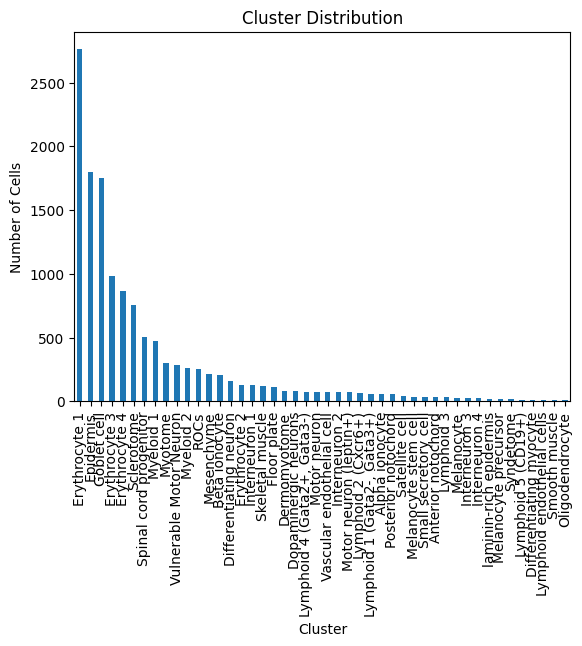

In [5]:
# Check the distribution of the 'cluster' column
cluster_distribution = adata.obs['cluster'].value_counts()

import matplotlib.pyplot as plt

# Plot the distribution of clusters
cluster_distribution.plot(kind='bar')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Cells')
plt.show()


We need to select a timepoint. Let's plot them out first.

<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

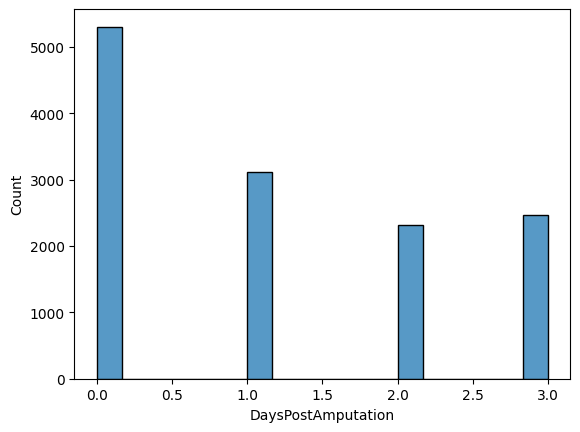

In [6]:
import seaborn as sns
sns.histplot(adata.obs['DaysPostAmputation'])

Selecting timepoint 0 (Day of amputation).

In [7]:
adata = adata[adata.obs['DaysPostAmputation'] == 0] # Subset on the time point 0
adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer

<ipython-input-7-88f00e64bca0>:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer


# 1.Data Visualization:

In [8]:
import scanpy as sc

sc.pp.normalize_total(adata, target_sum=1e4) # Normalize
sc.pp.log1p(adata) # Log normalization
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) # Identify highly variable genes
hvg_adata = adata[:, adata.var['highly_variable']].copy() # Select HVG
sc.pp.scale(hvg_adata) # Scale data


In [9]:
hvg_adata.obs.head()

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
1604,AAACCTGGTAATTGGA.1,AAACCTGGTAATTGGA.1,SIGAA5,st40,0,Differentiating neuron,10.943213,-1.818803,G1,SIGAA5,SLX-15583,ST40_0,3
1605,AAACCTGTCGCTTGTC.1,AAACCTGTCGCTTGTC.1,SIGAA5,st40,0,Erythrocyte 1,-4.683115,2.029120,G1,SIGAA5,SLX-15583,ST40_0,3
1606,AAACGGGAGGTGTTAA.1,AAACGGGAGGTGTTAA.1,SIGAA5,st40,0,Erythrocyte 3,-8.668563,4.375178,G1,SIGAA5,SLX-15583,ST40_0,3
1607,AAACGGGTCCCTGACT.1,AAACGGGTCCCTGACT.1,SIGAA5,st40,0,Differentiating neuron,9.162257,-2.653667,G2M,SIGAA5,SLX-15583,ST40_0,3
1608,AAAGATGAGTTATCGC.1,AAAGATGAGTTATCGC.1,SIGAA5,st40,0,Erythrocyte 3,-8.441736,5.272697,G1,SIGAA5,SLX-15583,ST40_0,3


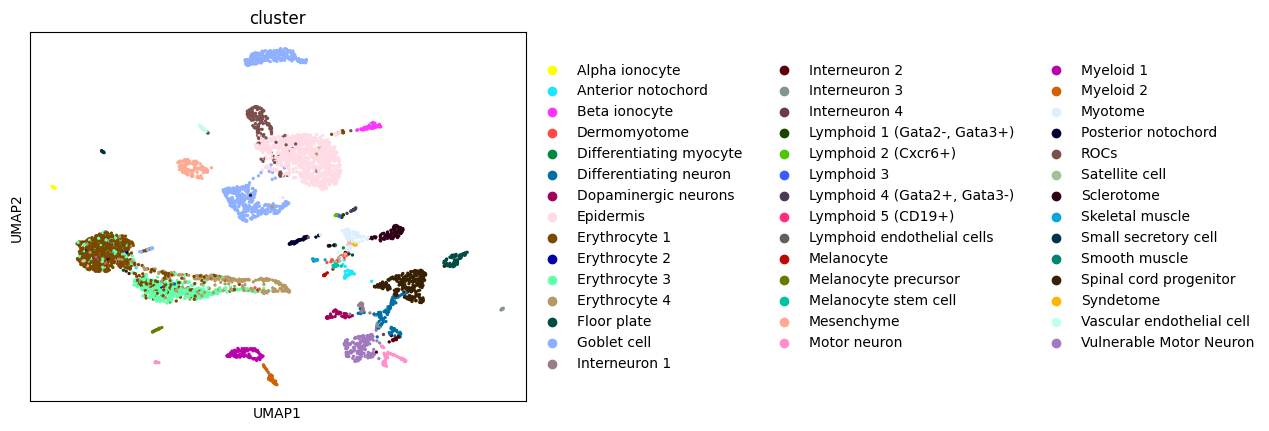

In [39]:
# 运行PCA以便后续降维
sc.tl.pca(hvg_adata, svd_solver='arpack')

# 计算邻近图
sc.pp.neighbors(hvg_adata, n_neighbors=10, n_pcs=40)

# 运行UMAP
sc.tl.umap(hvg_adata)

# 可视化UMAP
sc.pl.umap(hvg_adata, color=['cluster'])  # 根据细胞类型进行着色

# 2. Clustering

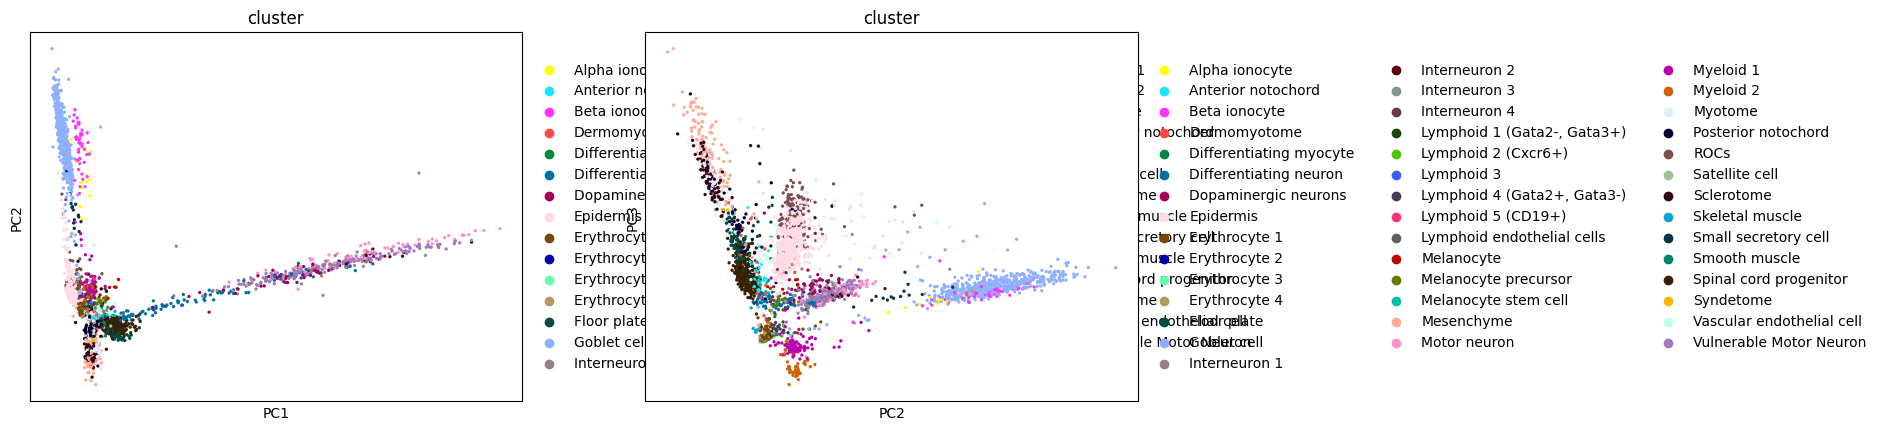

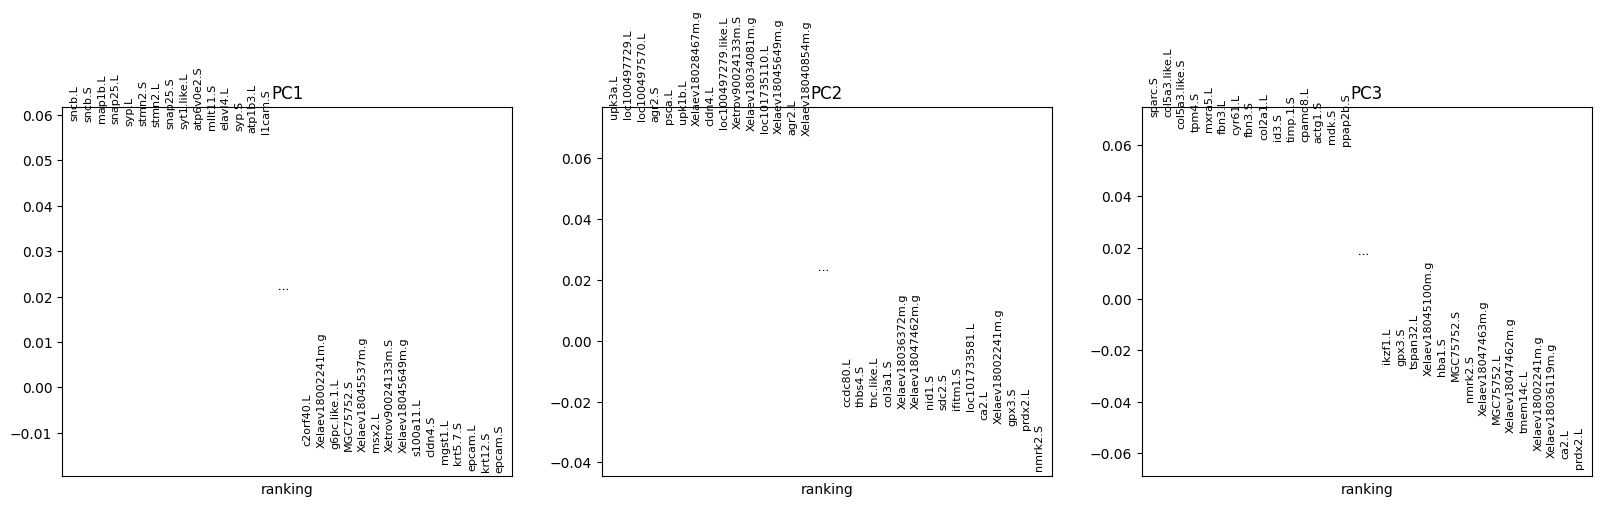

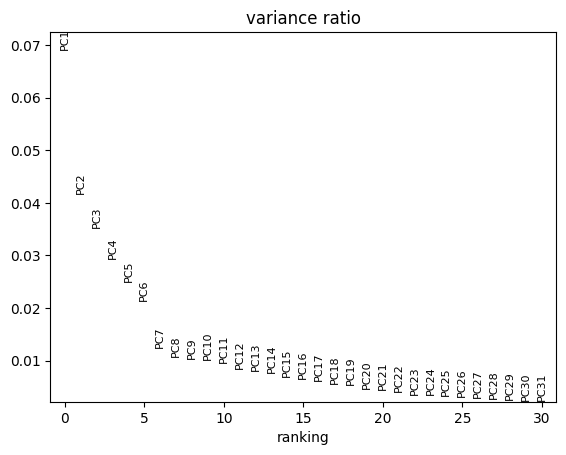

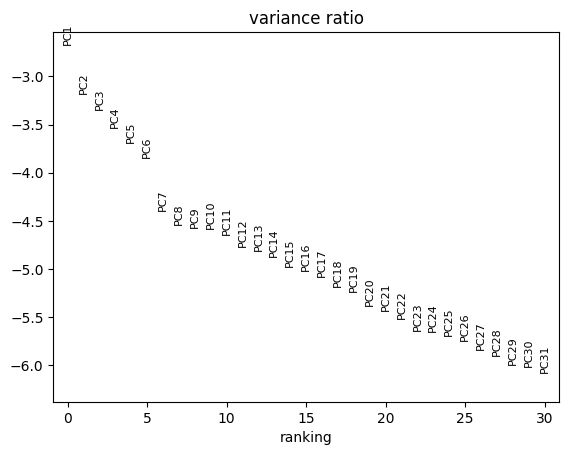

In [13]:
# Step 1: Data Scaling and PCA

import scanpy as sc
from sklearn.metrics import adjusted_rand_score, silhouette_score
import numpy as np

# Perform PCA
sc.tl.pca(hvg_adata)

# PCA diagnostic plots
sc.pl.pca_overview(hvg_adata, color='cluster', components=['1,2', '2,3'])
sc.pl.pca_variance_ratio(hvg_adata, log=True)  # Variance ratio plot


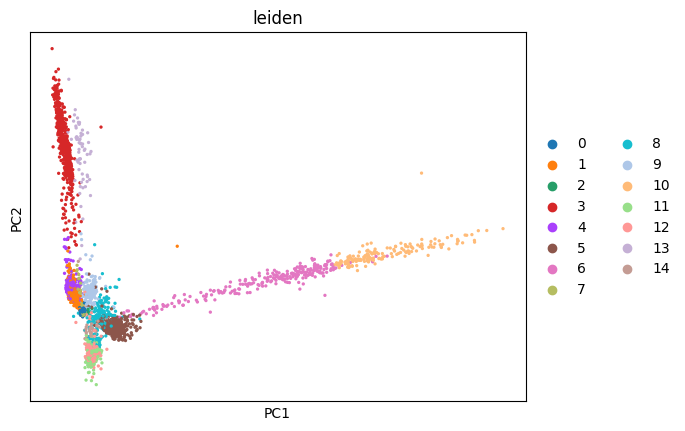

In [40]:
# Step 2: Clustering with Leiden
# Create neighbors graph - adjust n_pcs based on explained variance
sc.pp.neighbors(hvg_adata, n_pcs=10)

# Apply Leiden clustering with a specific resolution
sc.tl.leiden(hvg_adata, resolution=0.5)

# Visualize Leiden clustering
sc.pl.pca(hvg_adata, color=['leiden'])


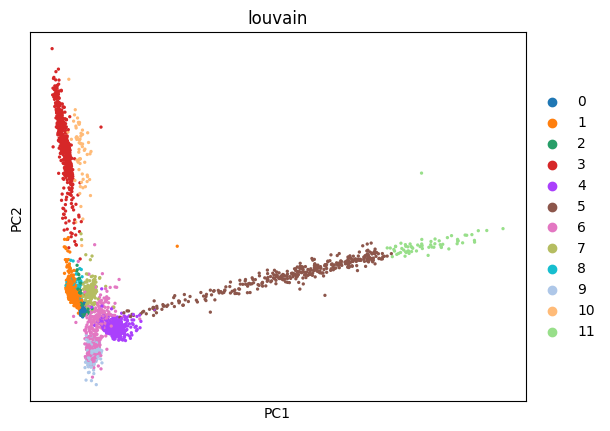

In [41]:
# Step 3: Clustering with Louvain
!pip install python-igraph louvain

# Apply Louvain clustering
sc.tl.louvain(hvg_adata, resolution=0.5)

# Visualize Louvain clustering
sc.pl.pca(hvg_adata, color=['louvain'])


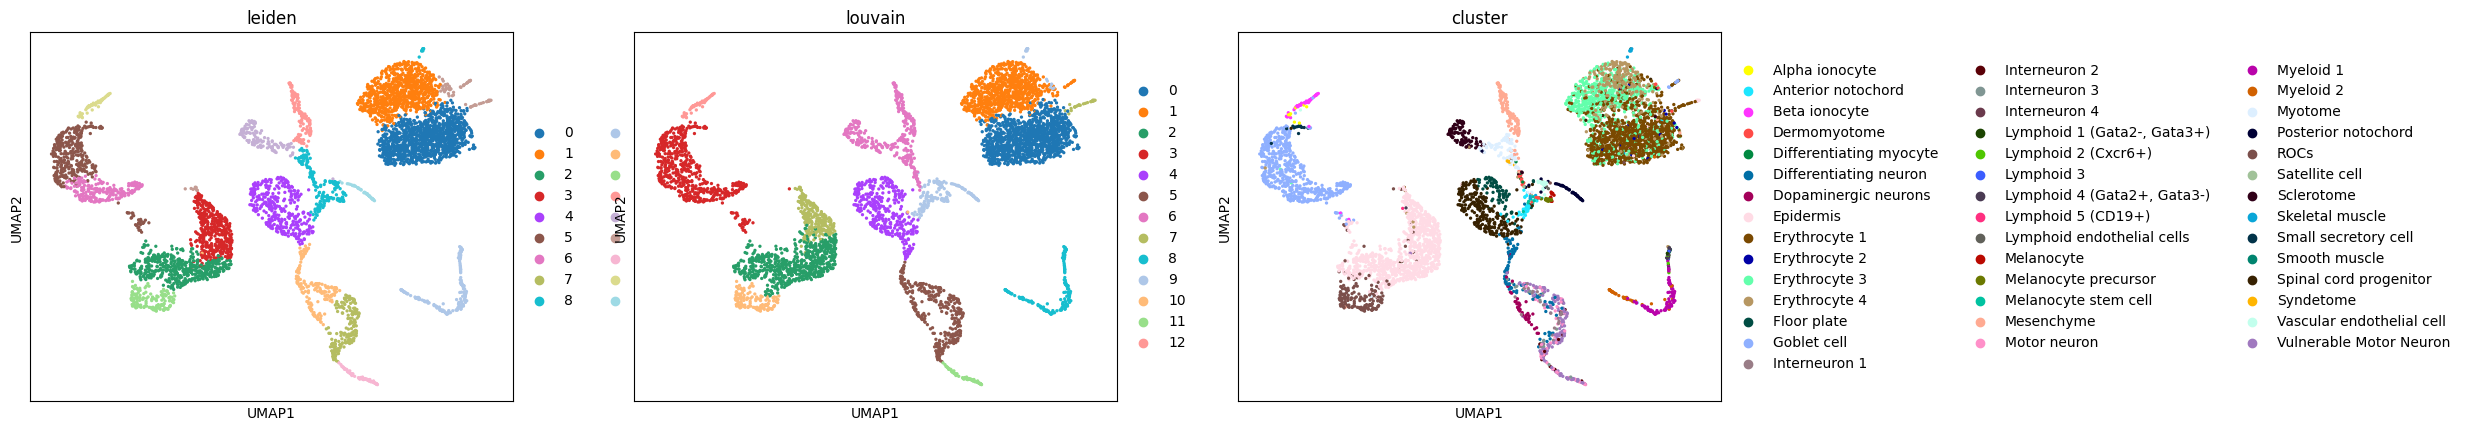

In [18]:
# Step 4: Visualize Clusters using UMAP

# UMAP for visualization
sc.tl.umap(hvg_adata)
sc.pl.umap(hvg_adata, color=['leiden', 'louvain', 'cluster'])


In [42]:
# Step 5: Compute Clustering Metrics

from sklearn.metrics import adjusted_rand_score, silhouette_score

# ARI (Adjusted Rand Index) between Leiden and Louvain clusters
leiden_labels = hvg_adata.obs['leiden']
louvain_labels = hvg_adata.obs['louvain']
ari_score = adjusted_rand_score(leiden_labels, louvain_labels)

# Silhouette score for each clustering
silhouette_leiden = silhouette_score(hvg_adata.X, leiden_labels)
silhouette_louvain = silhouette_score(hvg_adata.X, louvain_labels)

print(f"Adjusted Rand Index (ARI) between Leiden and Louvain: {ari_score}")
print(f"Silhouette Score for Leiden: {silhouette_leiden}")
print(f"Silhouette Score for Louvain: {silhouette_louvain}")


Adjusted Rand Index (ARI) between Leiden and Louvain: 0.843774885929184
Silhouette Score for Leiden: -0.07332295634851933
Silhouette Score for Louvain: -0.07716220686652965


In [20]:
# Step 6: Optional – Bonus Metric

from sklearn.metrics import normalized_mutual_info_score

nmi_score = normalized_mutual_info_score(leiden_labels, louvain_labels)
print(f"Normalized Mutual Information (NMI) between Leiden and Louvain: {nmi_score}")


Normalized Mutual Information (NMI) between Leiden and Louvain: 0.8852221038305723


# 3. Marker Selection and Gene Analysis:

In [31]:
# Step 1: Data Preparation and Label Transformation

import numpy as np
import scanpy as sc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Create a binary label column for ROC
hvg_adata.obs['ROC'] = np.where(hvg_adata.obs['cluster'] == 'ROCs', 1, 0)

# Split data into features (X) and labels (y)
X = hvg_adata.X
y = hvg_adata.obs['ROC']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [32]:
# Step 2: Logistic Regression for Feature Importance

# Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)

# Fit the model
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Evaluate the performance
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred))

# Get the coefficients (which genes are important)
coefficients = logreg.coef_[0]
important_genes = pd.DataFrame({
    'gene': hvg_adata.var_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

# Display top contributing genes
print(important_genes.head(20))


Accuracy: 0.9930861093651792
ROC AUC: 0.9799298280050053
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1538
           1       0.98      0.81      0.89        53

    accuracy                           0.99      1591
   macro avg       0.99      0.91      0.94      1591
weighted avg       0.99      0.99      0.99      1591

                   gene  coefficient
1573            lpar3.L     0.461588
1384  cdc42se2.like.2.S     0.418847
3544  Xelaev18047608m.g     0.386392
1666            alas1.L     0.293192
1336         atp6v1e1.S     0.248273
1826             bmp2.L     0.225803
3563          cldn6.1.S     0.206760
3097  Xelaev18042112m.g     0.193156
645             fstl1.L     0.182282
2295             cpa6.L     0.170736
1443             sncb.S     0.166907
2397     loc100127750.S     0.158780
3125  Xetrov90020904m.S     0.149271
3449             pltp.S     0.140994
942              btg2.S     0.140780
1535  Xetrov90011359m.L 

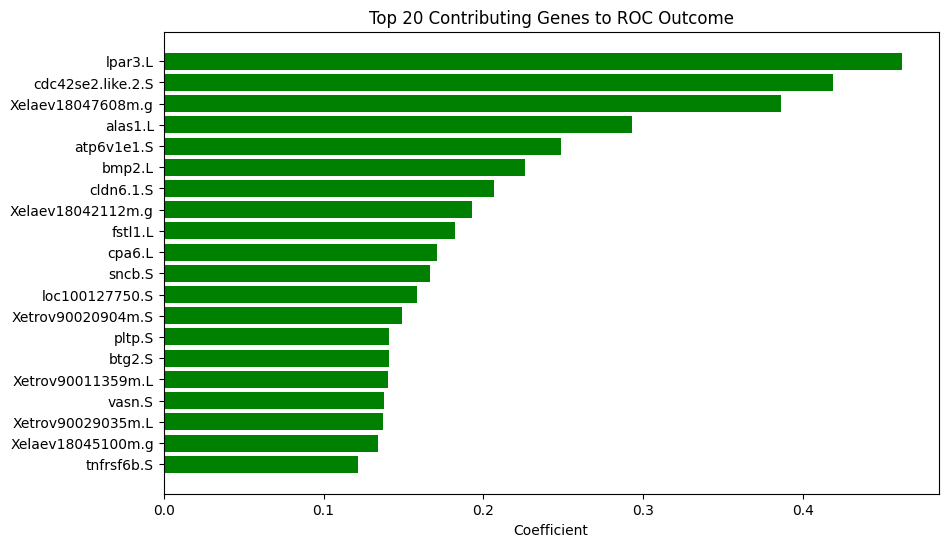

In [34]:
# Step 3: Visualization of Important Genes

import matplotlib.pyplot as plt

# Plot top 20 important genes
top_genes = important_genes.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_genes['gene'], top_genes['coefficient'], color='green')
plt.xlabel('Coefficient')
plt.title('Top 20 Contributing Genes to ROC Outcome')
plt.gca().invert_yaxis()
plt.show()


In [35]:
# Step 4: Exploring Other Classifiers

from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Random Forest ROC AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])}")


Random Forest Accuracy: 0.9899434318038969
Random Forest ROC AUC: 0.9802733272812033


                   gene  importance
3449             pltp.S    0.035722
886             mxra5.S    0.028738
7             frem2.1.L    0.025552
85    Xetrov90029035m.L    0.024425
300             fras1.L    0.020894
2276            lama1.L    0.020430
2295             cpa6.L    0.018111
2190             vwde.L    0.016640
3513              fn1.S    0.015599
978           tinagl1.S    0.014208
2177            bambi.L    0.013492
867              mmp3.L    0.013477
2931             nid2.L    0.012856
2420             cpa6.S    0.012048
3467  Xelaev18046800m.g    0.010922
2157     loc100486548.L    0.010808
1573            lpar3.L    0.010774
940              optc.S    0.010722
2665             vwa2.S    0.010487
3200            lama5.L    0.009669


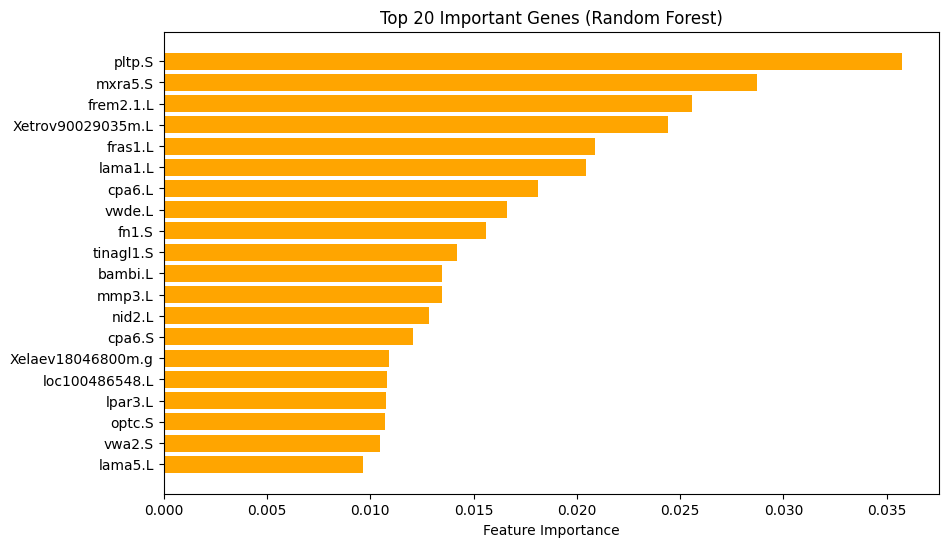

In [36]:

import pandas as pd
import numpy as np

feature_importances = rf.feature_importances_

important_genes_rf = pd.DataFrame({
    'gene': hvg_adata.var_names,
    'importance': feature_importances
})

important_genes_rf = important_genes_rf.sort_values(by='importance', ascending=False)

print(important_genes_rf.head(20))
import matplotlib.pyplot as plt

top_genes_rf = important_genes_rf.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_genes_rf['gene'], top_genes_rf['importance'], color='orange')
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Genes (Random Forest)')
plt.gca().invert_yaxis()
plt.show()
